In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

OpenBLAS WARNING - could not determine the L2 cache size on this system, assuming 256k


In [115]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182441, 3]) torch.Size([182441])
torch.Size([22902, 3]) torch.Size([22902])
torch.Size([22803, 3]) torch.Size([22803])


In [125]:
g = torch.Generator().manual_seed(2147483647)

emb_dim = 10
emb_size = 27
nsize = 200

C = torch.randn((emb_size, emb_dim), generator=g)
W1 = torch.randn((30, nsize), generator=g)
b1 = torch.randn(nsize, generator=g)
W2 = torch.randn((nsize, emb_size), generator=g)
b2 = torch.randn(emb_size, generator=g)

parameters = [C, W1, b1, W2, b2]

In [126]:
sum(p.nelement() for p in parameters)

11897

In [127]:
for p in parameters:
  p.requires_grad = True

In [128]:
lri = []
lossi = []
stepi = []

## Training

In [129]:
for i in range(200000):
  # minibatch construction
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # Forward pass
  emb = C[Xtr[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, Ytr[ix])

  # Backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
    
  # track
  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())
    
#print(loss.item())

In [104]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1651, grad_fn=<NllLossBackward0>)

We've got `2.16` with `10` dimensions for embedding and `300` neurons per layer. Training with 50k passes with LR of `0.1` until `~2.4` loss and then with LR of `0.01` with a lot more passes

In [105]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0783, grad_fn=<NllLossBackward0>)

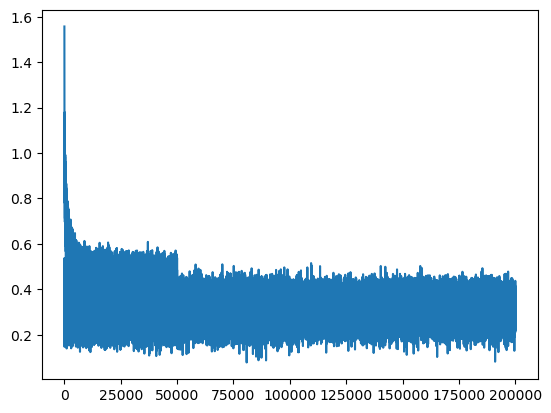

In [106]:
plt.plot(stepi, lossi)

## How to Sample

In [189]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [190]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

morahmayah.
deen.
ndhayah.
remmani.
jernegradelyn.
eliah.
milah.
reden.
carlear.
emyziah.
karin.
shrancishirael.
jonie.
jenslen.
priyan.
zaredaryandreyah.
yumajaysen.
daihaan.
adyansyn.
zarelle.
